## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/geno/geno_klek_train.csv")
df_test = pd.read_csv("../../data/train/geno/geno_klek_test.csv")
df_valid = pd.read_csv("../../data/train/geno/geno_klek_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'genotoxicity']
y_train = df_train_all['genotoxicity']

X_test = df_test.loc[:, df_test.columns != 'genotoxicity']
y_test = df_test['genotoxicity']

In [5]:
X_train.shape, y_train.shape

((19931, 4860), (19931,))

In [6]:
X_test.shape, y_test.shape

((4984, 4860), (4984,))

## 3. Remove low variance features

In [7]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,KRFP1,KRFP2,KRFP10,KRFP14,KRFP16,KRFP17,KRFP20,KRFP33,KRFP34,KRFP45,...,KRFP4813,KRFP4820,KRFP4826,KRFP4829,KRFP4833,KRFP4834,KRFP4843,KRFP4853,KRFP4856,KRFP4857
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2487,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2489,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [8]:
X_test

,KRFP1,KRFP2,KRFP10,KRFP14,KRFP16,KRFP17,KRFP20,KRFP33,KRFP34,KRFP45,...,KRFP4813,KRFP4820,KRFP4826,KRFP4829,KRFP4833,KRFP4834,KRFP4843,KRFP4853,KRFP4856,KRFP4857
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4979,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4980,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# write

with open('../../klek_idxs.txt', 'r+') as json_file:
    json_data = json.load(json_file)
    json_data['genotoxicity'] = idxs.tolist()
    json_file.seek(0)
    json.dump(json_data, json_file)
    json_file.truncate()

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [8]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [9]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 50, 'solver': 'lsqr', 'tol': 0.0001} 

Test set:
Tuned model:
MAE: 0.3384211013579658
MSE: 0.20982150682685538
RMSE: 0.45806277607644064
R2 Square 0.09202588521739974 

Base model:
MAE: 0.3384039788379554
MSE: 0.20960069390100938
RMSE: 0.4578216835199152
R2 Square 0.09298142320733038 

Train set:
Tuned model:
MAE: 0.3371851971649907
MSE: 0.20861653013149956
RMSE: 0.4567455857821721
R2 Square 0.14015318500596152 

Base model:
MAE: 0.3383597871824283
MSE: 0.21010522220742195
RMSE: 0.4583723619585085
R2 Square 0.1340172995170127 



In [10]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [17]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 10, 15],
    'n_estimators': [500, 800, 1000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 15, 'n_estimators': 1000} 

Test set:
Tuned model:
MAE: 0.32810722761150146
MSE: 0.19795648401756155
RMSE: 0.44492300908984417
R2 Square 0.1433701622892154 

Base model:
MAE: 0.3328562537844606
MSE: 0.20200267645639378
RMSE: 0.4494470785936802
R2 Square 0.12586081325513188 

Train set:
Tuned model:
MAE: 0.283885111807962
MSE: 0.14025475492562373
RMSE: 0.3745060145386503
R2 Square 0.4219173129063677 

Base model:
MAE: 0.3003540116920658
MSE: 0.1576277878751232
RMSE: 0.3970236616061103
R2 Square 0.35031154399151954 



In [11]:
params = {'max_depth': 15, 'n_estimators': 1000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.32810722761150146
MSE: 0.19795648401756155
RMSE: 0.44492300908984417
R2 Square 0.1433701622892154 

Train set:
MAE: 0.283885111807962
MSE: 0.14025475492562373
RMSE: 0.3745060145386503
R2 Square 0.4219173129063677 



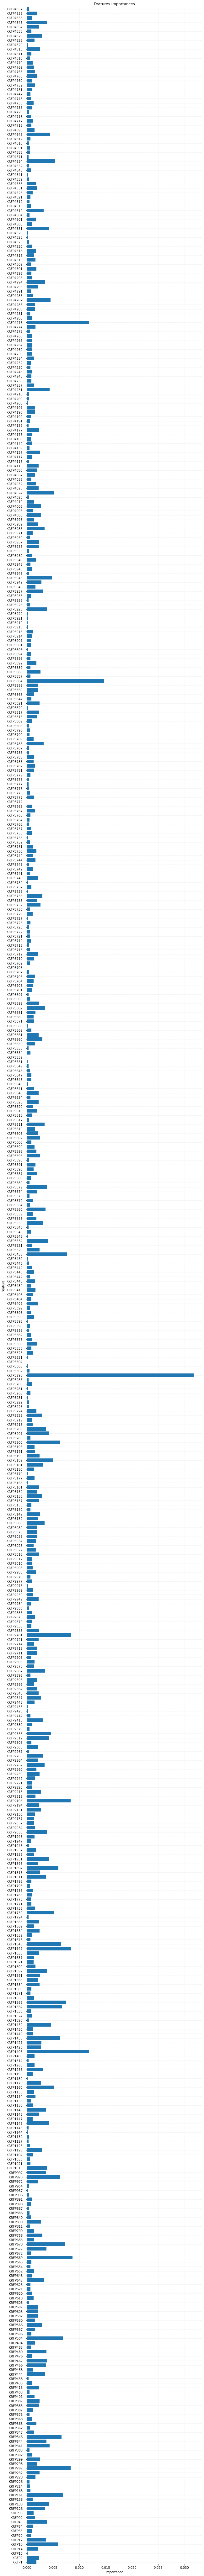

In [19]:
fig, ax = plt.subplots(figsize=(10, 150))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [12]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026
1,Random Forest Regressor,0.328107,0.197956,0.444923,0.143370


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [23]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 1500, 2000],
    'min_child_weight': [80, 95, 100],
    'colsample_bytree': [0.2],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 80, 'n_estimators': 2000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.32187752370405864
MSE: 0.19190461471386805
RMSE: 0.43806918941403317
R2 Square 0.16955880594591888 

Base model:
MAE: 0.32658996857024036
MSE: 0.1995587407535795
RMSE: 0.4467199802489021
R2 Square 0.13643661356229264 

Train set:
Tuned model:
MAE: 0.2916673432473898
MSE: 0.15928459189677072
RMSE: 0.39910473800341023
R2 Square 0.3434827578920434 

Base model:
MAE: 0.28371388026038397
MSE: 0.14315995550456667
RMSE: 0.37836484443532364
R2 Square 0.4099430582145256 



In [14]:
params = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 80, 'n_estimators': 2000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.32187752370405864
MSE: 0.19190461471386805
RMSE: 0.43806918941403317
R2 Square 0.16955880594591888 

Train set:
MAE: 0.2916673432473898
MSE: 0.15928459189677072
RMSE: 0.39910473800341023
R2 Square 0.3434827578920434 



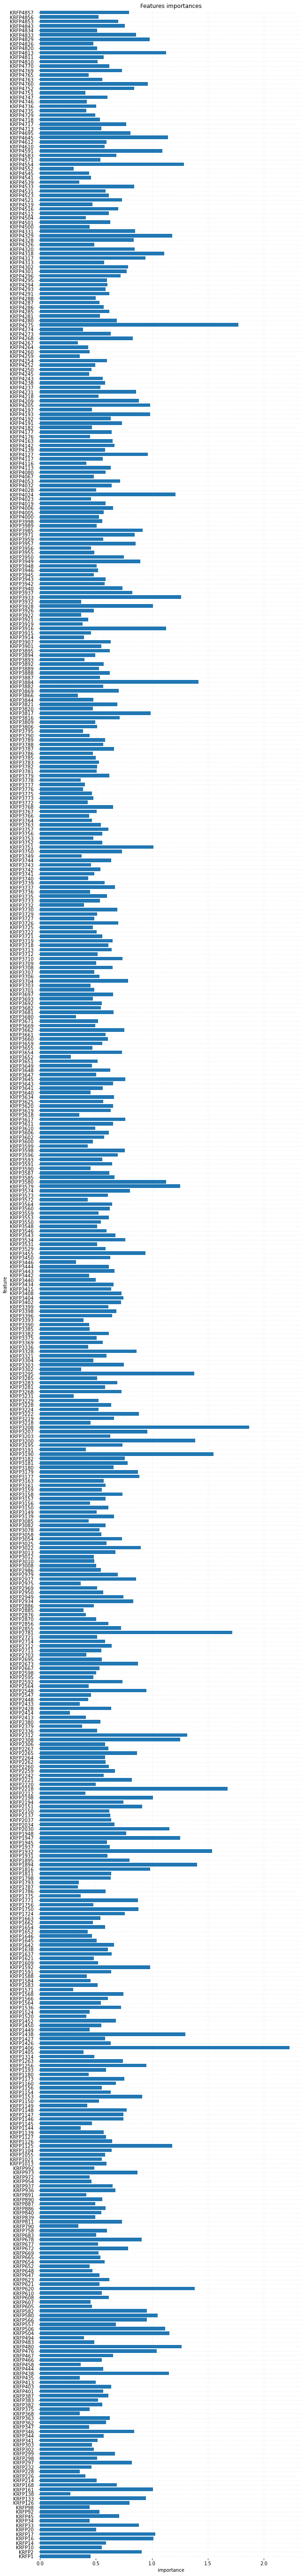

In [25]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [15]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026
1,Random Forest Regressor,0.328107,0.197956,0.444923,0.143370
2,XGBoost,0.321878,0.191905,0.438069,0.169559


## 5.4. LightGBM

Better results - third model.

In [31]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 2000, 3000],
    'min_child_samples': [55, 65, 80, 95],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.04, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.9],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 80, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.3234982913260226
MSE: 0.1938150261434703
RMSE: 0.44024428008035527
R2 Square 0.16129175957447595 

Base model:
MAE: 0.3252688561619346
MSE: 0.1941050155520521
RMSE: 0.4405735075467567
R2 Square 0.16003686973722642 

Train set:
Tuned model:
MAE: 0.2951155700219704
MSE: 0.16262830329166061
RMSE: 0.40327199666188157
R2 Square 0.329701109854167 

Base model:
MAE: 0.3071702965276855
MSE: 0.17292356192948058
RMSE: 0.41584078916032347
R2 Square 0.2872675340311517 



In [17]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 80, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.3235146194747952
MSE: 0.1938984552507824
RMSE: 0.4403390230842395
R2 Square 0.16093073142724534 

Train set:
MAE: 0.2950237327236119
MSE: 0.16258614775835412
RMSE: 0.40321972640032644
R2 Square 0.32987486071190175 



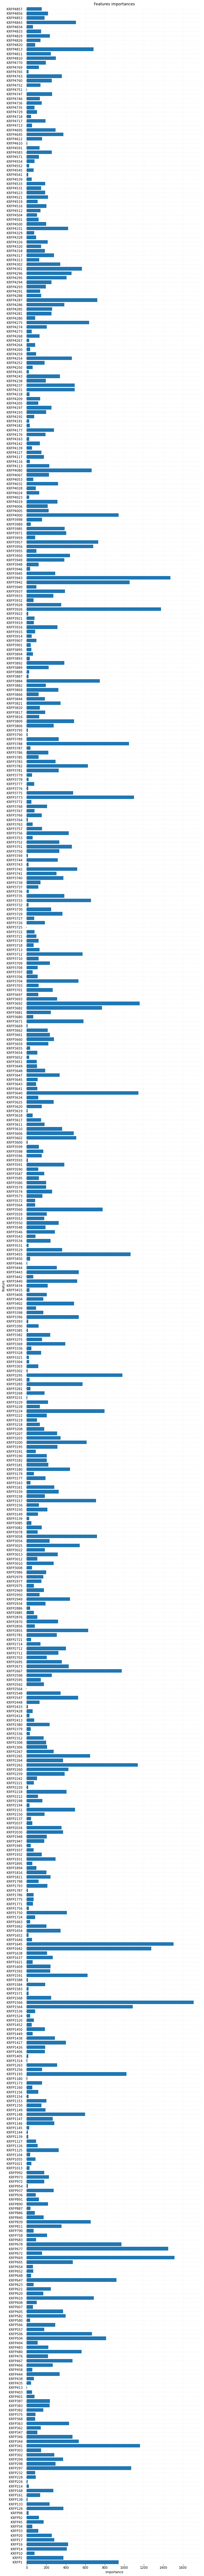

In [33]:
fig, ax = plt.subplots(figsize=(10, 150))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [15]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026
1,Random Forest Regressor,0.328107,0.197956,0.444923,0.143370
2,XGBoost,0.321878,0.191905,0.438069,0.169559
3,LightGBM,0.323515,0.193898,0.440339,0.160931


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [10]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [2, 5, 10, 15, 25],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[5, 10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 20} 

Test set:
Tuned model:
MAE: 0.32545318180123606
MSE: 0.19479288514467033
RMSE: 0.4413534696189329
R2 Square 0.15706020736410375 

Base model:
MAE: 0.32511839863391195
MSE: 0.19472943785015462
RMSE: 0.4412815856685554
R2 Square 0.15733476692639292 

Train set:
Tuned model:
MAE: 0.30775335987912394
MSE: 0.1746398449591579
RMSE: 0.41789932395154444
R2 Square 0.2801935955672813 

Base model:
MAE: 0.3072962734278638
MSE: 0.17423671954643472
RMSE: 0.4174167216900093
R2 Square 0.28185514224315933 



In [11]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 25, 'min_samples_leaf': 20} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.32545318180123606
MSE: 0.19479288514467033
RMSE: 0.4413534696189329
R2 Square 0.15706020736410375 

Train set:
MAE: 0.30775335987912394
MSE: 0.1746398449591579
RMSE: 0.41789932395154444
R2 Square 0.2801935955672813 



In [23]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 150))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 150))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [16]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026
1,Random Forest Regressor,0.328107,0.197956,0.444923,0.143370
2,XGBoost,0.321878,0.191905,0.438069,0.169559
3,LightGBM,0.323515,0.193898,0.440339,0.160931
4,HistGradient Boosting Regressor,0.325453,0.194793,0.441353,0.157060


## 5.6. Support Vector Regression

Better results - fifth model.

In [9]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.5, 2.0, 3.0],
    'epsilon': [0.2, 1.8, 2.8, 3.8],
}
               
grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')

Best params:  {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.32108617700345415
MSE: 0.19220176470822756
RMSE: 0.4384082169716115
R2 Square 0.16827292964483564 

Base model:
MAE: 0.3039773291659492
MSE: 0.19160153914848443
RMSE: 0.4377231306984867
R2 Square 0.17087032435198246 

Train set:
Tuned model:
MAE: 0.2071939142881794
MSE: 0.08086611556454139
RMSE: 0.2843696811626398
R2 Square 0.6666972081968693 

Base model:
MAE: 0.21371784257517135
MSE: 0.12429963110502534
RMSE: 0.35256152811250596
R2 Square 0.48767893971192044 



In [19]:
params = {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.32108617700345415
MSE: 0.19220176470822756
RMSE: 0.4384082169716115
R2 Square 0.16827292964483564 

Train set:
MAE: 0.2071939142881794
MSE: 0.08086611556454139
RMSE: 0.2843696811626398
R2 Square 0.6666972081968693 



In [63]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [20]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026
1,Random Forest Regressor,0.328107,0.197956,0.444923,0.143370
2,XGBoost,0.321878,0.191905,0.438069,0.169559
3,LightGBM,0.323515,0.193898,0.440339,0.160931
4,HistGradient Boosting Regressor,0.325453,0.194793,0.441353,0.157060
5,Support Vector Regression,0.321086,0.192202,0.438408,0.168273


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 5.7. Stacking models

### Averaging base models

In [29]:
def average_predictions(X):
    return ((0.10 * rf_best.predict(X)) + \
            (0.25 * xgbr_best.predict(X)) + \
            (0.20 * lgbm_best.predict(X)) + \
            (0.20 * hist_best.predict(X)) + \
            (0.25 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.3177159006200677
MSE: 0.18676444486219942
RMSE: 0.43216252135301997
R2 Square 0.1918021938687421 

Train set:
MAE: 0.2686589410294493
MSE: 0.1326459120530248
RMSE: 0.36420586493496343
R2 Square 0.453278391080136 



In [30]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026
1,Random Forest Regressor,0.328107,0.197956,0.444923,0.143370
2,XGBoost,0.321878,0.191905,0.438069,0.169559
3,LightGBM,0.323515,0.193898,0.440339,0.160931
4,HistGradient Boosting Regressor,0.325453,0.194793,0.441353,0.157060
5,Support Vector Regression,0.321086,0.192202,0.438408,0.168273
6,Averaging base models,0.317716,0.186764,0.432163,0.191802


### Averaging base models with Meta-model

In [32]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [33]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.026082,5.210869,5.201846,5.159962,5.460178
1,5.086848,5.151561,5.164551,5.130241,5.088962
2,5.383298,5.685815,5.648646,5.494895,5.424822
3,5.018674,4.944277,5.000889,5.009299,4.949823
4,4.799212,4.744182,4.750618,4.792845,4.686401
...,...,...,...,...,...
19926,4.777855,4.700950,4.723734,4.816932,4.750138
19927,5.062860,5.047110,5.005083,5.227994,5.107253
19928,5.002511,5.096737,5.069724,5.042219,5.266405
19929,4.941276,5.145557,5.124054,5.007717,5.202596


In [34]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.33223297155938897
MSE: 0.21221742393843007
RMSE: 0.46067062413228616
R2 Square 0.08165787885154285 

Train set:
MAE: 0.16682724395166904
MSE: 0.057471360608543486
RMSE: 0.23973185146855952
R2 Square 0.7631224795969875 



In [35]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026
1,Random Forest Regressor,0.328107,0.197956,0.444923,0.143370
2,XGBoost,0.321878,0.191905,0.438069,0.169559
3,LightGBM,0.323515,0.193898,0.440339,0.160931
4,HistGradient Boosting Regressor,0.325453,0.194793,0.441353,0.157060
5,Support Vector Regression,0.321086,0.192202,0.438408,0.168273
6,Averaging base models,0.317716,0.186764,0.432163,0.191802
7,Base models + Meta-model,0.332233,0.212217,0.460671,0.081658


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [9]:
params_rf = {'max_depth': 15, 'n_estimators': 1000} 

params_xgb = {'colsample_bytree': 0.2, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 80, 'n_estimators': 2000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 80, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.04, 
          'subsample': 0.9}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth':10, 'min_samples_leaf': 10} 

params_svr = {'C': 3.0, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'} 

In [10]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])

test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = 6

kf = KFold(n_splits=n_splits,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx] 
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    test1 += model1.predict(X_test)/n_splits   
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))
    del model1

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    test2 += model2.predict(X_test)/n_splits
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    del model2
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    test3 += model3.predict(X_test)/n_splits
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    del model3
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    test4 += model4.predict(X_test)/n_splits
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    del model4
    
    
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    test5 += model5.predict(X_test)/n_splits
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    del model5
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.20109892536797963
Model1 R2: 0.13948996265447655
Model2 MSE: 0.19356328634939615
Model2 R2: 0.17173525188930494
Model3 MSE: 0.19485656958969821
Model3 R2: 0.16620124315517437
Model4 MSE: 0.2012011141912237
Model4 R2: 0.13905269274890586
Model5 MSE: 0.19100855396092395
Model5 R2: 0.18266705005276784
Average MSE = 0.19634568989184434
Average R2 = 0.15982924010012592
-------------- fold 2 --------------
Model1 MSE: 0.20356557055893423
Model1 R2: 0.14976030737146995
Model2 MSE: 0.20031581065820353
Model2 R2: 0.16333369727000324
Model3 MSE: 0.20236060653633517
Model3 R2: 0.15479312425396174
Model4 MSE: 0.20353113760103808
Model4 R2: 0.14990412475403392
Model5 MSE: 0.1954174989656581
Model5 R2: 0.18379265315548687
Average MSE = 0.20103812486403383
Average R2 = 0.16031678136099115
-------------- fold 3 --------------
Model1 MSE: 0.19354431431498229
Model1 R2: 0.16811154501024905
Model2 MSE: 0.18922938124660854
Model2 R2: 0.18665790746134048
M

In [11]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [12]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.022366,5.152986,5.141896,5.027126,5.257122
1,5.281610,5.176725,5.186054,5.312193,5.373471
2,5.351115,5.742741,5.702035,5.348541,5.626706
3,5.040881,5.000461,5.015291,5.035577,5.039065
4,4.808982,4.829376,4.812599,4.821849,4.908599
...,...,...,...,...,...
19926,4.820864,4.729840,4.764430,4.809372,4.686912
19927,5.065375,5.063972,4.999555,5.073688,5.079288
19928,4.995117,5.068319,5.049493,4.994124,5.127562
19929,4.874348,5.047250,5.013281,4.859948,5.219789


In [13]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,5.955552,5.684818,5.664949,5.997365,6.524723
1,4.978097,4.883763,4.899911,4.984818,4.960753
2,5.011544,5.016588,5.026996,5.007168,4.954779
3,4.831491,4.898805,4.932396,4.832433,4.774498
4,4.994906,4.893491,4.869937,4.996191,4.861539
...,...,...,...,...,...
4979,5.124436,5.116453,5.106962,5.135710,5.371797
4980,5.021137,5.068426,5.043521,5.025401,5.049294
4981,5.002241,5.129777,5.127752,5.000282,5.129527
4982,4.967411,4.879034,4.871514,4.967546,4.769140


In [14]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.313436443519396
MSE: 0.18510282633098799
RMSE: 0.4302357799288525
R2 Square 0.19899262271371287 

Train set:
MAE: 0.3201010889539953
MSE: 0.19388509746609175
RMSE: 0.440323855208972
R2 Square 0.20087117053503567 



In [16]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.338421,0.209822,0.458063,0.092026
1,Random Forest Regressor,0.328107,0.197956,0.444923,0.143370
2,XGBoost,0.321878,0.191905,0.438069,0.169559
3,LightGBM,0.323515,0.193898,0.440339,0.160931
4,HistGradient Boosting Regressor,0.325453,0.194793,0.441353,0.157060
5,Support Vector Regression,0.321086,0.192202,0.438408,0.168273
6,Averaging base models,0.317716,0.186764,0.432163,0.191802
7,Base models + Meta-model,0.332233,0.212217,0.460671,0.081658
8,Base models + Meta-model + cv,0.313436,0.185103,0.430236,0.198993
